# Proximal Policy Optimization

## Imports

In [1]:
import gym
gym.logger.set_level(40)

import argparse, os
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta
from collections import deque

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

from utils import save_config, update_linear_schedule, create_directory
from utils.wrappers import make_env_atari
from utils.plot import plot_reward
from utils.hyperparameters import PolicyConfig

from IPython.display import clear_output

from agents.A2C import Model

## Hyperparameters

In [2]:
config = PolicyConfig()
config.algo = 'ppo'
config.env_id = 'BreakoutNoFrameskip-v4'

#preprocessing
config.stack_frames = 4
config.adaptive_repeat = [4]

#Recurrent control
config.recurrent_policy_grad = False
config.gru_size = 512 #also used as outp size of first fc layer
if config.recurrent_policy_grad:
    model_architecture = 'recurrent/'
else:
    model_architecture = 'feedforward/'

#ppo control
config.ppo_epoch = 4
config.num_mini_batch = 4
config.ppo_clip_param = 0.1
config.use_ppo_vf_clip = False   
    
#a2c control
config.num_agents=8
config.rollout=128    
    
#gae control
config.USE_GAE = True
config.gae_tau = 0.95

#adam params
config.adam_eps = 1e-5

#misc agent variables
config.GAMMA=0.99
config.LR=2.5e-4
config.entropy_loss_weight=0.01
config.value_loss_weight=0.5
config.grad_norm_max=0.5

#recurrency
config.recurrent_policy = False
config.gru_size = 512

#training loop params
config.seed = None
config.inference = False
config.sticky_actions = 0.0
config.print_threshold = 10
config.save_threshold = 100
config.use_lr_schedule = True
config.render = False

config.MAX_FRAMES=1e7

max_epochs = int(config.MAX_FRAMES / config.num_agents / config.rollout)

## Rollout Storage

In [3]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

def _flatten_helper(T, N, _tensor):
    return _tensor.view(T * N, *_tensor.size()[2:])

class RolloutStorage(object):
    def __init__(self, num_steps, num_processes, obs_shape, action_space, state_size, device, USE_GAE=True, gae_tau=0.95):
        self.observations = torch.zeros(num_steps + 1, num_processes, *obs_shape).to(device)
        self.states = torch.zeros(num_steps + 1, num_processes, state_size).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.value_preds = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.action_log_probs = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(num_steps, num_processes, 1).to(device, torch.long)
        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)

        self.num_steps = num_steps
        self.step = 0
        self.gae = USE_GAE
        self.gae_tau = gae_tau

    def insert(self, current_obs, state, action, action_log_prob, value_pred, reward, mask):
        self.observations[self.step + 1].copy_(current_obs)
        self.states[self.step + 1].copy_(state)
        self.actions[self.step].copy_(action)
        self.action_log_probs[self.step].copy_(action_log_prob)
        self.value_preds[self.step].copy_(value_pred)
        self.rewards[self.step].copy_(reward)
        self.masks[self.step + 1].copy_(mask)

        self.step = (self.step + 1) % self.num_steps

    def after_update(self):
        self.observations[0].copy_(self.observations[-1])
        self.states[0].copy_(self.states[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value, gamma):
        if self.gae:
            self.value_preds[-1] = next_value
            gae = 0
            for step in reversed(range(self.rewards.size(0))):
                delta = self.rewards[step] + gamma * self.value_preds[step + 1] * self.masks[step + 1] - self.value_preds[step]
                gae = delta + gamma * self.gae_tau * self.masks[step + 1] * gae
                self.returns[step] = gae + self.value_preds[step]
        else:
            self.returns[-1] = next_value
            for step in reversed(range(self.rewards.size(0))):
                self.returns[step] = self.returns[step + 1] * \
                    gamma * self.masks[step + 1] + self.rewards[step]

    def feed_forward_generator(self, advantages, num_mini_batch):
        num_steps, num_processes = self.rewards.size()[0:2]
        batch_size = num_processes * num_steps
        assert batch_size >= num_mini_batch, (
            f"PPO requires the number processes ({num_processes}) "
            f"* number of steps ({num_steps}) = {num_processes * num_steps} "
            f"to be greater than or equal to the number of PPO mini batches ({num_mini_batch}).")
        mini_batch_size = batch_size // num_mini_batch
        sampler = BatchSampler(SubsetRandomSampler(range(batch_size)), mini_batch_size, drop_last=False)
        for indices in sampler:
            observations_batch = self.observations[:-1].view(-1,
                                        *self.observations.size()[2:])[indices]
            states_batch = self.states[:-1].view(-1, self.states.size(-1))[indices]
            actions_batch = self.actions.view(-1, self.actions.size(-1))[indices]
            value_preds_batch = self.value_preds[:-1].view(-1, 1)[indices]
            return_batch = self.returns[:-1].view(-1, 1)[indices]
            masks_batch = self.masks[:-1].view(-1, 1)[indices]
            old_action_log_probs_batch = self.action_log_probs.view(-1, 1)[indices]
            adv_targ = advantages.view(-1, 1)[indices]

            yield observations_batch, states_batch, \
                actions_batch, value_preds_batch, return_batch, masks_batch, \
                old_action_log_probs_batch, adv_targ

    def recurrent_generator(self, advantages, num_mini_batch):
        num_processes = self.rewards.size(1)
        assert num_processes >= num_mini_batch, (
            f"PPO requires the number processes ({num_processes}) "
            f"to be greater than or equal to the number of PPO mini batches ({num_mini_batch}).")
        num_envs_per_batch = num_processes // num_mini_batch
        perm = torch.randperm(num_processes)
        for start_ind in range(0, num_processes, num_envs_per_batch):
            observations_batch = []
            states_batch = []
            actions_batch = []
            value_preds_batch = []
            return_batch = []
            masks_batch = []
            old_action_log_probs_batch = []
            adv_targ = []

            for offset in range(num_envs_per_batch):
                ind = perm[start_ind + offset]
                observations_batch.append(self.observations[:-1, ind])
                states_batch.append(self.states[0:1, ind])
                actions_batch.append(self.actions[:, ind])
                value_preds_batch.append(self.value_preds[:-1, ind])
                return_batch.append(self.returns[:-1, ind])
                masks_batch.append(self.masks[:-1, ind])
                old_action_log_probs_batch.append(self.action_log_probs[:, ind])
                adv_targ.append(advantages[:, ind])

            T, N = self.num_steps, num_envs_per_batch
            # These are all tensors of size (T, N, -1)
            observations_batch = torch.stack(observations_batch, 1)
            actions_batch = torch.stack(actions_batch, 1)
            value_preds_batch = torch.stack(value_preds_batch, 1)
            return_batch = torch.stack(return_batch, 1)
            masks_batch = torch.stack(masks_batch, 1)
            old_action_log_probs_batch = torch.stack(old_action_log_probs_batch, 1)
            adv_targ = torch.stack(adv_targ, 1)

            # States is just a (N, -1) tensor
            states_batch = torch.stack(states_batch, 1).view(N, -1)

            # Flatten the (T, N, ...) tensors to (T * N, ...)
            observations_batch = _flatten_helper(T, N, observations_batch)
            actions_batch = _flatten_helper(T, N, actions_batch)
            value_preds_batch = _flatten_helper(T, N, value_preds_batch)
            return_batch = _flatten_helper(T, N, return_batch)
            masks_batch = _flatten_helper(T, N, masks_batch)
            old_action_log_probs_batch = _flatten_helper(T, N, \
                    old_action_log_probs_batch)
            adv_targ = _flatten_helper(T, N, adv_targ)

            yield observations_batch, states_batch, \
                actions_batch, value_preds_batch, return_batch, masks_batch, \
                old_action_log_probs_batch, adv_targ

## Agent

In [4]:
import torch.optim as optim
from agents.A2C import Model as A2C

class Model(A2C):
    def __init__(self, static_policy=False, env=None, config=None, log_dir='/tmp/gym', tb_writer=None):
        super(Model, self).__init__(static_policy, env, config, log_dir, tb_writer=tb_writer)

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.config.LR, eps=self.config.adam_eps)

    def compute_loss(self, sample, next_value, clip_param):
        observations_batch, states_batch, actions_batch, value_preds_batch, return_batch, masks_batch, old_action_log_probs_batch, adv_targ = sample

        values, action_log_probs, dist_entropy, states = self.evaluate_actions(observations_batch,
                                                            actions_batch,
                                                            states_batch,
                                                            masks_batch)

        ratio = torch.exp(action_log_probs - old_action_log_probs_batch)
        surr1 = ratio * adv_targ
        surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * adv_targ
        action_loss = -torch.min(surr1, surr2).mean()

        if self.config.use_ppo_vf_clip:
            value_pred_clipped = value_preds_batch + (values - value_preds_batch).clamp(-clip_param, clip_param)
            value_losses = (values - return_batch).pow(2)
            value_losses_clipped = (value_pred_clipped - return_batch).pow(2)
            value_loss = 0.5 * torch.max(value_losses, value_losses_clipped).mean()
        else:
            value_loss = 0.5 * (return_batch - values).pow(2).mean()

        loss = action_loss + self.config.value_loss_weight * value_loss
        loss -= self.config.entropy_loss_weight * dist_entropy

        return loss, action_loss, value_loss, dist_entropy

    def update(self, rollout, next_value, frame):
        rollout.compute_returns(next_value, self.config.GAMMA)

        advantages = rollout.returns[:-1] - rollout.value_preds[:-1]
        advantages = (advantages - advantages.mean()) / (
            advantages.std() + 1e-5)

        value_loss_epoch = 0
        action_loss_epoch = 0
        dist_entropy_epoch = 0

        if self.config.anneal_ppo_clip:
            clip_param = self.linear_anneal_scalar(self.config.ppo_clip_param, frame, self.config.MAX_FRAMES)
        else:
            clip_param = self.config.ppo_clip_param

        all_grad_norms = []
        all_sigma_norms = []

        for e in range(self.config.ppo_epoch):
            if self.model.use_gru:
                data_generator = rollout.recurrent_generator(
                    advantages, self.config.num_mini_batch)
            else:
                data_generator = rollout.feed_forward_generator(
                    advantages, self.config.num_mini_batch)


            for sample in data_generator:
                loss, action_loss, value_loss, dist_entropy = self.compute_loss(sample, next_value, clip_param)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.grad_norm_max)
                self.optimizer.step()

                with torch.no_grad():
                    grad_norm = 0.
                    for p in self.model.parameters():
                        param_norm = p.grad.data.norm(2)
                        grad_norm += param_norm.item() ** 2
                    grad_norm = grad_norm ** (1./2.)
                    all_grad_norms.append(grad_norm)

                    if self.config.noisy_nets:
                        sigma_norm = 0.
                        for name, p in self.model.named_parameters():
                            if p.requires_grad and 'sigma' in name:
                                param_norm = p.data.norm(2)
                                sigma_norm += param_norm.item() ** 2
                        sigma_norm = sigma_norm ** (1./2.)
                        all_sigma_norms.append(sigma_norm)

                value_loss_epoch += value_loss.item()
                action_loss_epoch += action_loss.item()
                dist_entropy_epoch += dist_entropy.item()
        
        value_loss_epoch /= (self.config.ppo_epoch * self.config.num_mini_batch)
        action_loss_epoch /= (self.config.ppo_epoch * self.config.num_mini_batch)
        dist_entropy_epoch /= (self.config.ppo_epoch * self.config.num_mini_batch)
        total_loss = value_loss_epoch + action_loss_epoch + dist_entropy_epoch

        self.tb_writer.add_scalar('Loss/Total Loss', total_loss, frame)
        self.tb_writer.add_scalar('Loss/Policy Loss', action_loss_epoch, frame)
        self.tb_writer.add_scalar('Loss/Value Loss', value_loss_epoch, frame)
        self.tb_writer.add_scalar('Loss/Forward Dynamics Loss', 0., frame)
        self.tb_writer.add_scalar('Loss/Inverse Dynamics Loss', 0., frame)
        self.tb_writer.add_scalar('Policy/Entropy', dist_entropy_epoch, frame)
        self.tb_writer.add_scalar('Policy/Value Estimate', 0, frame)
        self.tb_writer.add_scalar('Policy/Sigma Norm', np.mean(all_sigma_norms), frame)
        self.tb_writer.add_scalar('Learning/Learning Rate', np.mean([param_group['lr'] for param_group in self.optimizer.param_groups]), frame)
        self.tb_writer.add_scalar('Learning/Grad Norm', np.mean(all_grad_norms), frame)

        return value_loss_epoch, action_loss_epoch, dist_entropy_epoch, 0.
    
    def linear_anneal_scalar(self, initial_val, frame, max_frames):
        val = initial_val - (initial_val * (frame / float(max_frames)))
        return val

## Training Loop

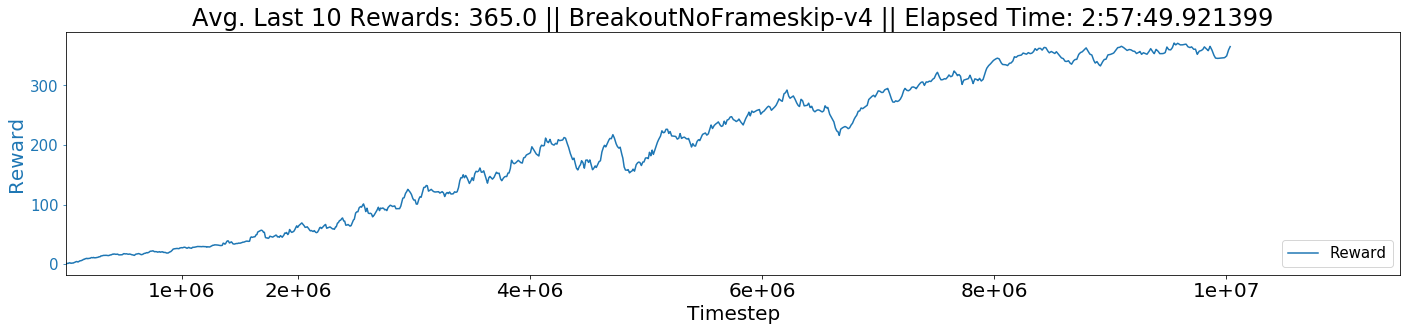

In [5]:
def train(config):
    #make/clear directories for logging
    base_dir = os.path.join('./results/', config.algo, model_architecture, config.env_id)
    log_dir = os.path.join(base_dir, 'logs/')   
    model_dir = os.path.join(base_dir, 'saved_model/')
    tb_dir = os.path.join(base_dir, 'runs/')
    create_directory(base_dir)
    create_directory(log_dir)
    create_directory(model_dir)
    create_directory(tb_dir)

    #Tensorboard writer
    writer = SummaryWriter(log_dir=os.path.join(base_dir, 'runs'))
    
    #save configuration for later reference
    save_config(config, base_dir)

    #set seeds
    seed = np.random.randint(0, int(1e6)) if config.seed is None else config.seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    envs = [make_env_atari(config.env_id, seed, i, log_dir, stack_frames=config.stack_frames, adaptive_repeat=config.adaptive_repeat, sticky_actions=config.sticky_actions, clip_rewards=True) for i in range(config.num_agents)]
    envs = SubprocVecEnv(envs)

    model = Model(env=envs, config=config, log_dir=base_dir, static_policy=config.inference, tb_writer=writer)

    obs = envs.reset()
    
    obs = torch.from_numpy(obs.astype(np.float32)).to(config.device)

    model.config.rollouts.observations[0].copy_(obs)
    
    episode_rewards = np.zeros(config.num_agents, dtype=np.float)
    final_rewards = np.zeros(config.num_agents, dtype=np.float)
    last_100_rewards = deque(maxlen=100)

    start = timer()
    
    last_log = timer()
    last_reward_logged = 0
    
    for epoch in range(1, max_epochs+1):
        if config.use_lr_schedule:
            update_linear_schedule(model.optimizer, epoch-1, max_epochs, config.LR)

        for step in range(config.rollout):
            with torch.no_grad():
                values, actions, action_log_prob, states = model.get_action(
                                                            model.config.rollouts.observations[step],
                                                            model.config.rollouts.states[step],
                                                            model.config.rollouts.masks[step])
            
            cpu_actions = actions.view(-1).cpu().numpy()
    
            obs, reward, done, info = envs.step(cpu_actions)

            obs = torch.from_numpy(obs.astype(np.float32)).to(config.device)

            #agent rewards
            episode_rewards += reward
            masks = 1. - done.astype(np.float32)
            final_rewards *= masks
            final_rewards += (1. - masks) * episode_rewards
            episode_rewards *= masks

            for index, inf in enumerate(info):
                current_tstep = (epoch-1)*config.rollout*config.num_agents \
                    +step*config.num_agents+index
                if 'episode' in inf.keys():
                    last_100_rewards.append(inf['episode']['r'])
                    writer.add_scalar('Performance/Environment Reward', inf['episode']['r'], current_tstep)
                    writer.add_scalar('Performance/Episode Length', inf['episode']['l'], current_tstep)

                if done[index]:
                    #write reward on completion
                    writer.add_scalar('Performance/Agent Reward', final_rewards[index], \
                        current_tstep)

            rewards = torch.from_numpy(reward.astype(
                np.float32)).view(-1, 1).to(config.device)
            masks = torch.from_numpy(masks).to(config.device).view(-1, 1)

            obs *= masks.view(-1, 1, 1, 1)

            model.config.rollouts.insert(obs, states, actions.view(-1, 1), 
                                         action_log_prob, values, rewards, 
                                         masks)
            
        with torch.no_grad():
            next_value = model.get_values(model.config.rollouts.observations[-1],
                                model.config.rollouts.states[-1],
                                model.config.rollouts.masks[-1])
            
        value_loss, action_loss, dist_entropy, dynamics_loss = model.update(model.config.rollouts, next_value, 
                                                                            epoch*config.rollout*config.num_agents)
        
        model.config.rollouts.after_update()

        if epoch % config.save_threshold == 0:
            model.save_w()

        if epoch % config.print_threshold == 0:
            #print
            end = timer()
            
            clear_output(True)
            plot_reward(log_dir, config.env_id, config.MAX_FRAMES, bin_size=10, smooth=1, \
                time=timedelta(seconds=end-start), save_filename='results.png', ipynb=True)
    
    clear_output(True)
    plot_reward(log_dir, config.env_id, config.MAX_FRAMES, bin_size=10, smooth=1, \
        time=timedelta(seconds=end-start), save_filename='results.png', ipynb=True)

    model.save_w()
    envs.close()
            
    
if __name__=='__main__':
    train(config)